In [1]:
import pandas as pd

### Load Dataset

In [2]:
data_df = pd.read_csv('Iris.csv')
data_df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [3]:
data_df.isnull().sum()

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [5]:
print(data_df.shape)

(150, 6)


### Lable Encoder

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
encoder = LabelEncoder()
data_df['Encoded_species']= encoder.fit_transform(data_df['Species'])

In [8]:
data_df['Encoded_species'].unique()

array([0, 1, 2])

In [9]:
data_df['Encoded_species'].nunique()

3

### Data Selection

In [10]:
x = data_df[['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']]
y = data_df['Encoded_species']

In [11]:
print(x.shape)
print(y.shape)

(150, 4)
(150,)


### Splitting Data

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
x_train, x_test , y_train, y_test = train_test_split(x,y,test_size=0.2,stratify=y,random_state=42)

In [14]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)


(120, 4)
(120,)
(30, 4)
(30,)


### Standard Scaler

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [17]:
print(x_train_scaled.shape)
print(x_test_scaled.shape)

(120, 4)
(30, 4)


### Selecting Device


In [18]:
import torch

In [19]:
device = torch.device('cpu')
device


device(type='cpu')

### Convrting Data into Tensors


In [20]:
x_train_tensor = torch.tensor(x_train_scaled,dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_scaled,dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values,dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values,dtype=torch.long)

print(x_train_tensor.shape,x_train_tensor.dtype)
print(x_test_tensor.shape,x_test_tensor.dtype)
print(y_train_tensor.shape,y_train_tensor.dtype)
print(y_test_tensor.shape,y_test_tensor.dtype)

torch.Size([120, 4]) torch.float32
torch.Size([30, 4]) torch.float32
torch.Size([120]) torch.int64
torch.Size([30]) torch.int64


### Class Fun Model  Building

In [21]:
import torch
import torch.nn as nn

In [22]:
class IrisClassification(nn.Module):
    def __init__(self,input_size,output_size):
        super().__init__()
        self.input_layer = nn.Linear(input_size,9)
        self.relu = nn.ReLU()
        self.hidden_layer_1 = nn.Linear(9,6)
        self.output_layer = nn.Linear(6,output_size)

    def forward(self,x):
        out = self.input_layer(x)
        out = self.relu(out)
        out = self.hidden_layer_1(out)
        out = self.relu(out)
        out = self.output_layer(out)


        return out


input_size = x_train_tensor.shape[-1]
output_size = data_df['Encoded_species'].nunique()

model = IrisClassification(input_size,output_size)

### Graph Wiz

In [23]:
from torchview import draw_graph



(process:15780): Pango-WARNING **: 07:47:56.771: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


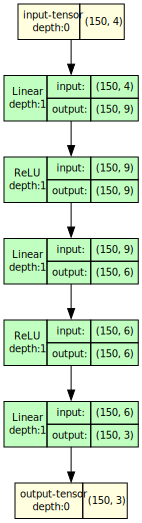

In [24]:
draw_graph(model,input_size=(150,4)).visual_graph

In [25]:
loss_count = nn.CrossEntropyLoss()

In [26]:
optimizer_iris = torch.optim.SGD(model.parameters(),lr=0.002)

In [27]:
train_losses = []
test_losses = []

for epoch in range(125):

    optimizer_iris.zero_grad()

    outputs_iris = model(x_train_tensor)

    loss = loss_count(outputs_iris,y_train_tensor)

    loss.backward()

    optimizer_iris.step()

    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        test_output = model(x_test_tensor)
        test_loss = loss_count(test_output,y_test_tensor)
        test_losses.append(test_loss.item())


    if epoch % 200 == 0:
        
        print(f'Train Loss :{train_losses[-1]}, Test Loss :{test_losses[-1]}')

Train Loss :1.1837226152420044, Test Loss :1.1722246408462524


### Plotting Train Vs Test

In [28]:

import matplotlib.pyplot as plt

Text(0, 0.5, 'loss')

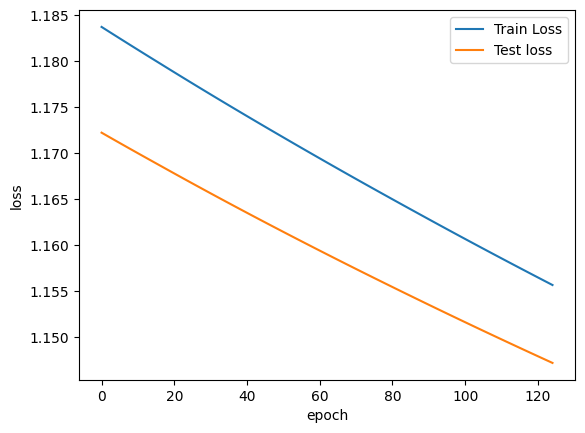

In [29]:
plt.plot(train_losses,label='Train Loss')
plt.plot(test_losses,label='Test loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

### Confusion Matrix

In [30]:
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00        40
           2       0.30      0.88      0.45        40

    accuracy                           0.29       120
   macro avg       0.10      0.29      0.15       120
weighted avg       0.10      0.29      0.15       120



C:\Users\OMKAR\.conda\envs\DeepLearning_Models\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\OMKAR\.conda\envs\DeepLearning_Models\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\OMKAR\.conda\envs\DeepLearning_Models\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

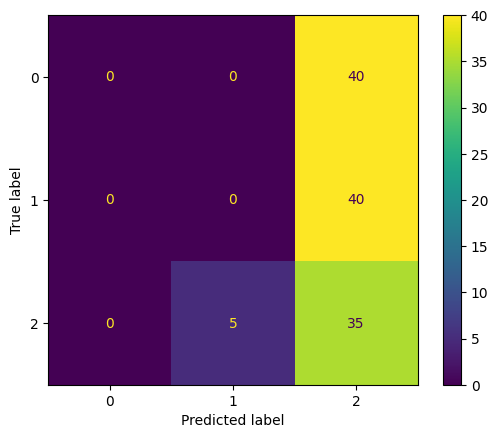

In [31]:
model.eval()
with torch.no_grad():
    output = model(x_train_tensor)
    _, predictions = torch.max(output,1)
    print(classification_report(y_train_tensor,predictions))
    cm = confusion_matrix(y_train_tensor,predictions)
    disp = ConfusionMatrixDisplay(cm)

    disp.plot()

C:\Users\OMKAR\.conda\envs\DeepLearning_Models\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\OMKAR\.conda\envs\DeepLearning_Models\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\OMKAR\.conda\envs\DeepLearning_Models\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.33      1.00      0.50        10

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30



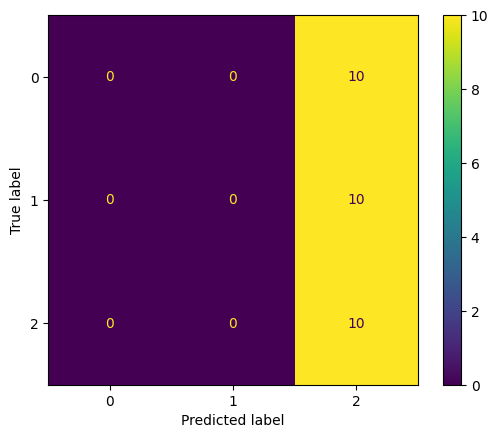

In [32]:
model.eval()
with torch.no_grad():
    output = model(x_test_tensor)
    _, predictions = torch.max(output,1)
    print(classification_report(y_test_tensor,predictions))
    cm = confusion_matrix(y_test_tensor,predictions)
    disp = ConfusionMatrixDisplay(cm)
    
    disp.plot()

### NLTK

In [35]:
import nltk
import re

# ---- DOWNLOAD ALL REQUIRED PACKAGES FOR NEW NLTK VERSION ----
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')  # NEW important fix!

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


# Function to map NLTK POS tags to WordNet POS tags
def get_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN


# MAIN PREPROCESS FUNCTION (UPDATED)
def preprocess(text):

    text = text.lower()   # lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove symbols/numbers

    tokens = word_tokenize(text)  # tokenize

    stop_words = set(stopwords.words("english"))
    tokens = [w for w in tokens if w not in stop_words]  # remove stopwords

    lemmatizer = WordNetLemmatizer()
    
    # FORCE POS TAGGER to use new tagger name
    pos_tags = nltk.pos_tag(tokens, tagset=None, lang='eng')  

    tokens = [lemmatizer.lemmatize(word, get_pos(tag)) 
              for word, tag in pos_tags]

    return " ".join(tokens)


# Test Example
print(preprocess("The striped bats are hanging on their feet for best."))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\OMKAR\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\OMKAR\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\OMKAR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\OMKAR\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\OMKAR\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\OMKAR\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\a

strip bat hang foot best
